In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
!pip install -q transformers peft datasets accelerate evaluate matplotlib seaborn nltk rouge-score tensorboard

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.9 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependen

In [3]:
!pip install -U bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 23.0 MB/s eta 0:00:00:00:0100:01


In [4]:
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset, load_dataset
from transformers import (
    AutoTokenizer, 
    AutoModelForSeq2SeqLM, 
    BitsAndBytesConfig, 
    TrainingArguments, 
    Seq2SeqTrainer, 
    Seq2SeqTrainingArguments,
    DataCollatorForSeq2Seq
)
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model, TaskType
from sklearn.model_selection import train_test_split
import evaluate
import nltk
from nltk.translate.bleu_score import sentence_bleu
import gc
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

2025-05-21 14:56:42.452132: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747839402.665357      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747839402.724768      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
# Configuration pour le tracking visuel de l'entraînement
writer = SummaryWriter()

In [6]:
# Vérification du GPU
print(f"GPU disponible: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Nombre de GPUs disponibles: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
        print(f"Mémoire GPU {i}: {torch.cuda.get_device_properties(i).total_memory / 1e9:.2f} GB")
    
    # Configuration pour utiliser spécifiquement le premier GPU (index 0)
    torch.cuda.set_device(0)
    print(f"Utilisation forcée du GPU 0: {torch.cuda.current_device()}")

GPU disponible: True
Nombre de GPUs disponibles: 1
GPU 0: Tesla T4
Mémoire GPU 0: 15.83 GB
Utilisation forcée du GPU 0: 0


In [7]:
# 1. Chargement et préparation des données
def load_data(file_path):
    df = pd.read_csv(file_path)
    return df

In [8]:
file_path = "/kaggle/input/dataset/Praphrased_Data_50k.csv" 
data_df = load_data(file_path)

In [9]:
# Affichage d'un aperçu des données
print("Aperçu des données:")
print(data_df.head())
print(f"Nombre total d'exemples: {len(data_df)}")

Aperçu des données:
                                                Text  \
0                        can you overdose from weed?   
1  more than 170,000 people have been killed in s...   
2         what are remedies to get rid of belly fat?   
3  within the common knowledge of most intelligen...   
4  currently there is no cure for alzheimer’s dis...   

                                          Paraphrase  
0           is it possible to overdose on marijuana?  
1  shi'ite militias from iraq and lebanon are sup...  
2  what is the best way to lose belly fat? workou...  
3  among the widely known information of most int...  
4  medication is available to slow down the devel...  
Nombre total d'exemples: 50000


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


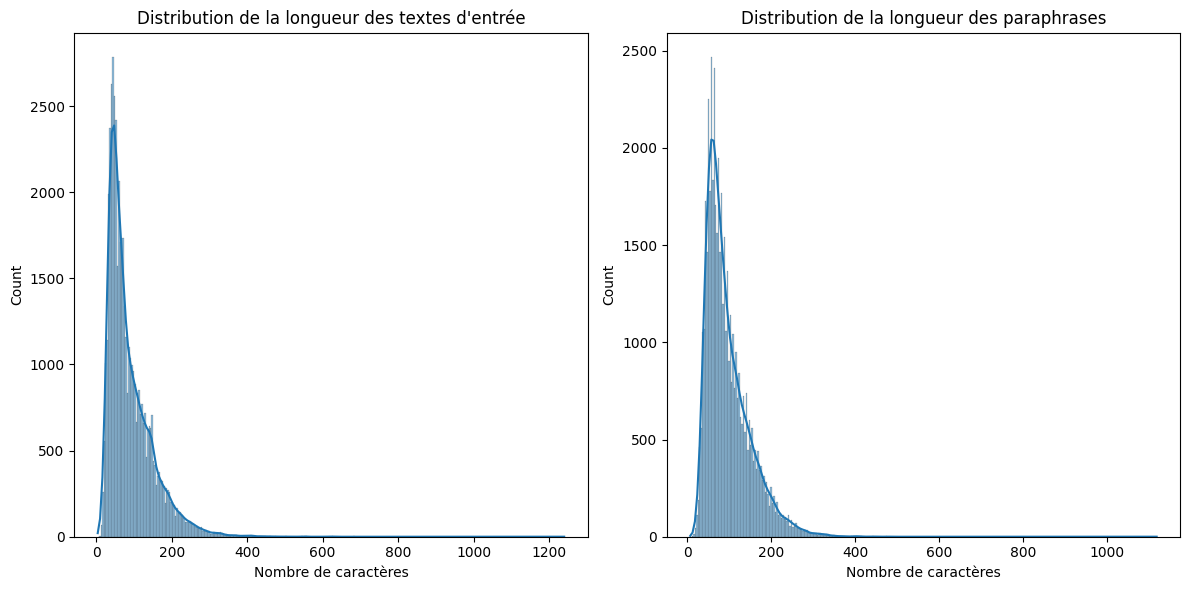

In [10]:

# Statistiques sur la longueur des textes
data_df['input_length'] = data_df['Text'].apply(len)
data_df['target_length'] = data_df['Paraphrase'].apply(len)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(data_df['input_length'], kde=True)
plt.title('Distribution de la longueur des textes d\'entrée')
plt.xlabel('Nombre de caractères')

plt.subplot(1, 2, 2)
sns.histplot(data_df['target_length'], kde=True)
plt.title('Distribution de la longueur des paraphrases')
plt.xlabel('Nombre de caractères')
plt.tight_layout()
plt.savefig('text_length_distribution.png')
plt.show()

In [11]:
# 2. Division des données en ensembles train/validation/test
train_df, temp_df = train_test_split(data_df, test_size=0.2, random_state=42)
test_df, val_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f"Taille de l'ensemble d'entraînement: {len(train_df)}")
print(f"Taille de l'ensemble de validation: {len(val_df)}")
print(f"Taille de l'ensemble de test: {len(test_df)}")


Taille de l'ensemble d'entraînement: 40000
Taille de l'ensemble de validation: 5000
Taille de l'ensemble de test: 5000


In [12]:
# Conversion en Datasets
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

In [13]:
# 3. Configuration du modèle et du tokenizer
model_name = "facebook/bart-base"  # Vous pouvez aussi utiliser "facebook/bart-large"


In [14]:
# Configuration pour la quantisation en 4 bits
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

In [15]:
# Assurer l'utilisation du GPU 0
torch.cuda.set_device(0)
print(f"Device CUDA actuel: {torch.cuda.current_device()}")

Device CUDA actuel: 0


In [16]:
# Chargement du tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)


config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [17]:
# Chargement du modèle avec quantisation
model = AutoModelForSeq2SeqLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    torch_dtype=torch.bfloat16, 
    device_map={'':torch.cuda.current_device()},
    )

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

In [18]:

model = prepare_model_for_kbit_training(model)

In [19]:
# Puis re-fixe tous les tensors sur cuda:0
model.cuda()

In [20]:

# 4. Configuration LoRA
lora_config = LoraConfig(
    r=16,                    # Rang de l'adaptation
    lora_alpha=32,           # Paramètre d'échelle
    target_modules=["q_proj", "v_proj", "k_proj", "o_proj", "fc1", "fc2"],  # Modules à adapter
    lora_dropout=0.05,       # Dropout pour la régularisation
    bias="none",             # Ne pas adapter les biais
    task_type=TaskType.SEQ_2_SEQ_LM,  # Type de tâche (séquence à séquence)
    modules_to_save=["encoder.embed_tokens", "decoder.embed_tokens"]  # Ajouter ceci pour garantir la backprop
)

In [21]:
# Application de LoRA au modèle
model = get_peft_model(model, lora_config)


In [22]:
# Affichage des paramètres adaptables vs total
model.print_trainable_parameters()

trainable params: 80,008,704 || all params: 219,429,120 || trainable%: 36.4622


In [23]:
# 5. Préparation des données pour l'entraînement
def preprocess_function(examples):
    inputs = examples["Text"]
    targets = examples["Paraphrase"]
    model_inputs = tokenizer(inputs, max_length=128, truncation=True, padding="max_length")
    
    # Tokenisation des cibles
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=128, truncation=True, padding="max_length")

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs


In [24]:
# Application de la tokenisation
tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_val = val_dataset.map(preprocess_function, batched=True)
tokenized_test = test_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3980: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [25]:
# Data collator pour le padding dynamique
data_collator = DataCollatorForSeq2Seq(
    tokenizer,
    model=model,
    padding="longest",
)

In [26]:
# 6. Métriques d'évaluation
rouge_metric = evaluate.load("rouge")
bleu_metric = evaluate.load("bleu")

In [27]:
def compute_metrics(eval_preds):
    preds, labels = eval_preds
    # Décodage des prédictions
    preds = np.where(preds != -100, preds, tokenizer.pad_token_id)
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    
    # Décodage des vraies étiquettes
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    # Calcul du ROUGE
    rouge_result = rouge_metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    
    # Calcul du BLEU
    bleu_result = bleu_metric.compute(predictions=decoded_preds, references=[[label] for label in decoded_labels])
    
    # Combinaison des résultats
    result = {
        "rouge1": rouge_result["rouge1"],
        "rouge2": rouge_result["rouge2"],
        "rougeL": rouge_result["rougeL"],
        "bleu": bleu_result["bleu"],
    }
    
    # Enregistrer pour TensorBoard
    for key, value in result.items():
        if key.startswith('rouge'):
            writer.add_scalar(f'eval/{key}', value, trainer.state.global_step)
        elif key == 'bleu':
            writer.add_scalar('eval/bleu', value, trainer.state.global_step)
    
    return result

In [28]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    eval_strategy="steps",
    eval_steps=200,
    save_strategy="steps",
    save_steps=200,
    learning_rate=5e-4,
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=16,   
    gradient_accumulation_steps=4, 
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=5,
    predict_with_generate=True,
    fp16=True,  # Activer la précision mixte pour accélérer l'entraînement
    logging_dir='./logs',
    logging_steps=50,
    optim="paged_adamw_8bit",  # Optimiseur optimisé pour la mémoire
    generation_max_length=128,
    report_to="tensorboard",
    dataloader_pin_memory=False,
)

In [29]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

/tmp/ipykernel_35/3690746773.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
No label_names provided for model class `PeftModelForSeq2SeqLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [30]:
batch = next(iter(trainer.get_train_dataloader()))
for k, v in batch.items():
    print(f"{k} -> {v.device}")

input_ids -> cuda:0
attention_mask -> cuda:0
labels -> cuda:0
decoder_input_ids -> cuda:0


In [31]:
print(f"Model is on device: {next(model.parameters()).device}")


Model is on device: cuda:0


In [32]:
print(f"Model is on device: {next(model.parameters()).device}")


Model is on device: cuda:0


In [33]:
print("Le debut de l'entrainement:")
trainer.train()

Le debut de l'entrainement:


/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Bleu
200,4.171900,4.044637,0.587394,0.344315,0.512509,0.288554
400,4.134000,4.019186,0.593930,0.349780,0.518118,0.298353
600,4.097700,4.009814,0.594060,0.352289,0.518469,0.297106
800,4.085500,4.007019,0.596892,0.355460,0.521371,0.302511
1000,4.072000,4.006314,0.597984,0.356087,0.520315,0.305977
1200,4.075400,4.002451,0.598671,0.356523,0.521816,0.305791
1400,4.040000,4.001271,0.595843,0.353433,0.516660,0.305358
1600,4.060000,4.001852,0.596853,0.355682,0.519953,0.303199
1800,4.044900,4.000250,0.597618,0.356972,0.519694,0.308351
2000,4.028900,4.001766,0.598653,0.355883,0.521101,0.307024


/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/

TrainOutput(global_step=3125, training_loss=4.102627263183594, metrics={'train_runtime': 12975.4185, 'train_samples_per_second': 15.414, 'train_steps_per_second': 0.241, 'total_flos': 1.56737470464e+16, 'train_loss': 4.102627263183594, 'epoch': 5.0})

In [34]:
# Évaluation sur l'ensemble de test
print("Évaluation sur l'ensemble de test...")
test_results = trainer.evaluate(tokenized_test)
print(f"Résultats de l'évaluation: {test_results}")


Évaluation sur l'ensemble de test...


Résultats de l'évaluation: {'eval_loss': 4.002953052520752, 'eval_rouge1': 0.5957093770943624, 'eval_rouge2': 0.3520579056145815, 'eval_rougeL': 0.5171870355241374, 'eval_bleu': 0.30316624460343955, 'eval_runtime': 579.0649, 'eval_samples_per_second': 8.635, 'eval_steps_per_second': 0.541, 'epoch': 5.0}


In [35]:
print("Sauvegarde du modèle...")
model.save_pretrained("./paraphrase_model_qlora")
tokenizer.save_pretrained("./paraphrase_model_qlora")

Sauvegarde du modèle...


('./paraphrase_model_qlora/tokenizer_config.json',
 './paraphrase_model_qlora/special_tokens_map.json',
 './paraphrase_model_qlora/vocab.json',
 './paraphrase_model_qlora/merges.txt',
 './paraphrase_model_qlora/added_tokens.json',
 './paraphrase_model_qlora/tokenizer.json')

In [37]:
# 13. Fonction pour générer des paraphrases avec le modèle entraîné
def generate_paraphrase(text, model, tokenizer, num_return_sequences=3):
    """Génère des paraphrases pour un texte donné."""
    inputs = tokenizer(text, return_tensors="pt", padding=True)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    
    # Génération de séquences
    outputs = model.generate(
        **inputs,
        max_length=128,
        num_beams=5,
        num_return_sequences=num_return_sequences,
        temperature=0.7,
        top_k=50,
        top_p=0.95,
        no_repeat_ngram_size=2,
        early_stopping=True
    )
    
    # Décodage des séquences générées
    paraphrases = [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]
    return paraphrases


In [39]:
# 14. Test du modèle sur quelques exemples
print("Test du modèle sur quelques exemples...")
test_examples = test_df['Text'].iloc[:5].tolist()

for i, text in enumerate(test_examples):
    print(f"\nTexte original #{i+1}: {text}")
    print(f"Paraphrase de référence: {test_df['Paraphrase'].iloc[i]}")
    
    generated_paraphrases = generate_paraphrase(text, model, tokenizer)
    print("Paraphrases générées:")
    for j, para in enumerate(generated_paraphrases):
        print(f"{j+1}. {para}")

Test du modèle sur quelques exemples...

Texte original #1: what is the best infinity ring at tiffany  co.?
Paraphrase de référence: which infinity ring is the most popular choice at tiffany  co.?


/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


Paraphrases générées:
1. what is the best infinity ring at tiffany  co?
2. what is the best infinity ring available at tiffany  co?
3. what is the best infinity ring that tiffany  co offers?

Texte original #2: will negative views of obama's presidency dampen the prospects of similarly aspiring african-americans?
Paraphrase de référence: can negative views of obama's presidency negatively impact the chances of other african-americans pursuing similar positions?
Paraphrases générées:
1. will the lack of enthusiasm for obama's presidency hinder the prospects of similarly aspiring african-americans?
2. will the lack of confidence in obama's presidency hinder the prospects of similarly aspiring african-americans?
3. is it possible for african-americans to be negatively influenced by obama's presidency?

Texte original #3: what is the worst case complexity mathomath to find the median of a set of numbers coming sequentially. is it possible to do it in less than mathonlog_2 nmath?
Paraphrase

Évaluation du modèle sur les exemples de test...


100%|██████████| 100/100 [00:58<00:00,  1.72it/s]
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Résultats d'évaluation sauvegardés dans 'evaluation_results.csv'


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


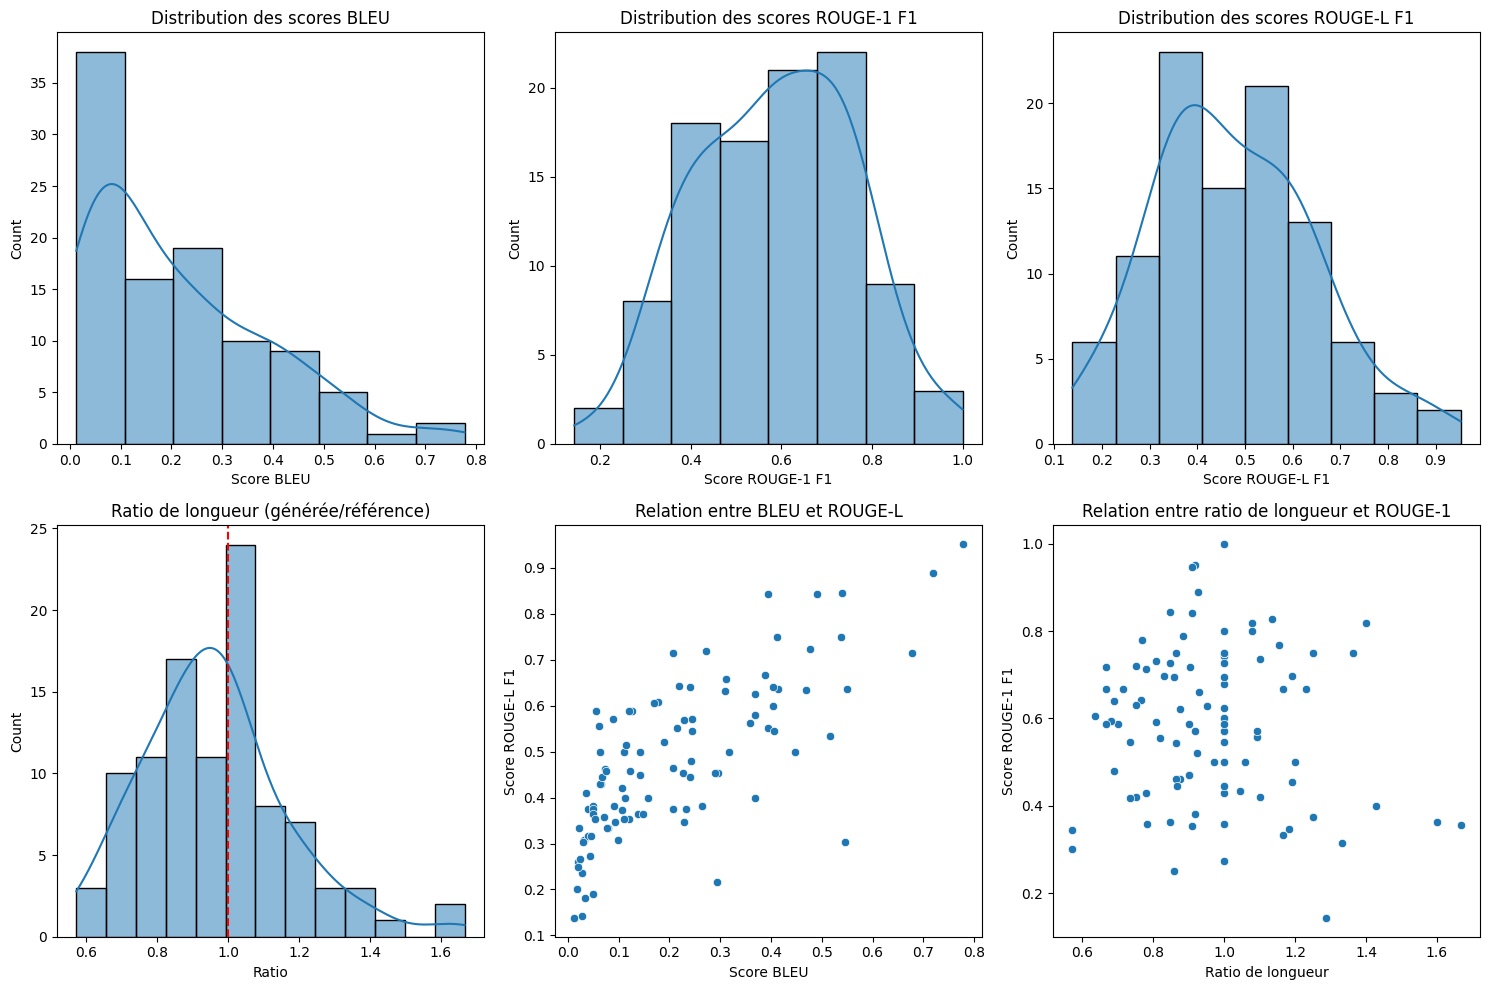

In [56]:
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import SmoothingFunction
from tqdm import tqdm

# 1. Évaluation détaillée du modèle
def evaluate_model(model, tokenizer, test_df, num_examples=None):
    """Évalue le modèle sur le jeu de test avec différentes métriques."""
    if num_examples is not None:
        test_df = test_df.sample(n=min(num_examples, len(test_df)), random_state=42)
    
    # Préparation des métriques
    rouge_scorer_instance = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    smoothing = SmoothingFunction().method1
    
    results = {
        'original': [],
        'reference': [],
        'generated': [],
        'bleu': [],
        'rouge1_precision': [],
        'rouge1_recall': [],
        'rouge1_f1': [],
        'rouge2_f1': [],
        'rougeL_f1': [],
        'length_ratio': []
    }
    
    print("Évaluation du modèle sur les exemples de test...")
    for i, row in tqdm(test_df.iterrows(), total=len(test_df)):
        original_text = row['Text']
        reference_text = row['Paraphrase']
        
        # Génération de paraphrase
        inputs = tokenizer(original_text, return_tensors="pt", padding=True)
        inputs = {k: v.to(model.device) for k, v in inputs.items()}
        
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_length=128,
                num_beams=5,
                temperature=0.7,
                top_p=0.95,
                no_repeat_ngram_size=2,
                early_stopping=True
            )
        
        generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
        
        # Calcul du BLEU
        reference_tokens = nltk.word_tokenize(reference_text.lower())
        generated_tokens = nltk.word_tokenize(generated_text.lower())
        bleu_score = sentence_bleu([reference_tokens], generated_tokens, smoothing_function=smoothing)
        
        # Calcul du ROUGE
        rouge_scores = rouge_scorer_instance.score(reference_text, generated_text)
        
        # Ratio de longueur
        length_ratio = len(generated_tokens) / max(1, len(reference_tokens))
        
        # Stockage des résultats
        results['original'].append(original_text)
        results['reference'].append(reference_text)
        results['generated'].append(generated_text)
        results['bleu'].append(bleu_score)
        results['rouge1_precision'].append(rouge_scores['rouge1'].precision)
        results['rouge1_recall'].append(rouge_scores['rouge1'].recall)
        results['rouge1_f1'].append(rouge_scores['rouge1'].fmeasure)
        results['rouge2_f1'].append(rouge_scores['rouge2'].fmeasure)
        results['rougeL_f1'].append(rouge_scores['rougeL'].fmeasure)
        results['length_ratio'].append(length_ratio)
    
    return pd.DataFrame(results)

# Évaluation sur l'ensemble de test (limité à 100 exemples pour plus de rapidité)
results_df = evaluate_model(model, tokenizer, test_df,num_examples=100)

# Sauvegarde des résultats
results_df.to_csv('evaluation_results.csv', index=False)
print(f"Résultats d'évaluation sauvegardés dans 'evaluation_results.csv'")

# 2. Visualisation des distributions de métriques
plt.figure(figsize=(15, 10))

# Distribution des scores BLEU
plt.subplot(2, 3, 1)
sns.histplot(results_df['bleu'], kde=True)
plt.title('Distribution des scores BLEU')
plt.xlabel('Score BLEU')

# Distribution des scores ROUGE-1 F1
plt.subplot(2, 3, 2)
sns.histplot(results_df['rouge1_f1'], kde=True)
plt.title('Distribution des scores ROUGE-1 F1')
plt.xlabel('Score ROUGE-1 F1')

# Distribution des scores ROUGE-L F1
plt.subplot(2, 3, 3)
sns.histplot(results_df['rougeL_f1'], kde=True)
plt.title('Distribution des scores ROUGE-L F1')
plt.xlabel('Score ROUGE-L F1')

# Distribution du ratio de longueur
plt.subplot(2, 3, 4)
sns.histplot(results_df['length_ratio'], kde=True)
plt.axvline(x=1.0, color='r', linestyle='--')
plt.title('Ratio de longueur (générée/référence)')
plt.xlabel('Ratio')

# Relation entre BLEU et ROUGE-L
plt.subplot(2, 3, 5)
sns.scatterplot(x='bleu', y='rougeL_f1', data=results_df)
plt.title('Relation entre BLEU et ROUGE-L')
plt.xlabel('Score BLEU')
plt.ylabel('Score ROUGE-L F1')

# Relation entre ratio de longueur et ROUGE-1
plt.subplot(2, 3, 6)
sns.scatterplot(x='length_ratio', y='rouge1_f1', data=results_df)
plt.title('Relation entre ratio de longueur et ROUGE-1')
plt.xlabel('Ratio de longueur')
plt.ylabel('Score ROUGE-1 F1')

plt.tight_layout()
plt.savefig('metrics_distribution.png')
plt.show()


In [57]:
import shutil

# Remplace 'model_folder' par le chemin réel de ton dossier de modèle (par ex : 'qlora_bart_model')
shutil.make_archive('/kaggle/working/paraphrase_model_qlora', 'zip', '/kaggle/working/paraphrase_model_qlora')

'/kaggle/working/paraphrase_model_qlora.zip'

In [45]:
text = " We experimented with several deep learning models for this task"


print(f"\nTexte original #{i+1}: {text}")
    
generated_paraphrases = generate_paraphrase(text, model, tokenizer)
print("Paraphrases générées:")
for j, para in enumerate(generated_paraphrases):
    print(f"{j+1}. {para}")


Texte original #5:  We experimented with several deep learning models for this task
Paraphrases générées:
1. we experimented with multiple deep learning models for this task.
2. we experimented with several deep learning models for this task.
3. we experimented with various deep learning models for this task.
